In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [15]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [16]:
df = pd.read_csv("../../../our_analyses/dataset_prepared.csv")

In [17]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

In [18]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)

In [20]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

### FInd the best number of cluster

In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

silhouette_scores = []
for k in range(2, 11):  # Prova con un numero di cluster da 2 a 10
    model = AgglomerativeClustering(n_clusters=k, linkage='single')
    labels = model.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Trova il numero ottimale di cluster
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Numero ottimale di cluster:", optimal_k)

# Ora puoi creare il modello con il numero ottimale di cluster
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='single')


Numero ottimale di cluster: 2


### Find the best distance threshold

In [22]:
# Range di valori per testare il distance_threshold
threshold_range = np.linspace(start=0.1, stop=0.6, num=20)

best_silhouette = -1
best_threshold = None

for threshold in threshold_range:
    model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, metric="euclidean", linkage='single')
    model = model.fit(X_pca)
    labels = model.labels_
    if len(set(labels)) > 1:  # Assicurati che ci siano almeno 2 cluster
        silhouette_avg = silhouette_score(X_pca, labels)
        print("Threshold:", threshold, "Silhouette:", silhouette_avg)
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_threshold = threshold

print("Miglior distance_threshold:", best_threshold, "con silhouette di:", best_silhouette)


Threshold: 0.1 Silhouette: -0.4960009756761079
Threshold: 0.12631578947368421 Silhouette: -0.6308785693501425
Threshold: 0.15263157894736842 Silhouette: -0.5920707275366622
Threshold: 0.17894736842105263 Silhouette: -0.4941631377919138
Threshold: 0.20526315789473684 Silhouette: -0.36409382695710785
Threshold: 0.23157894736842105 Silhouette: -0.18247832134666156
Threshold: 0.2578947368421053 Silhouette: -0.11101235861118193
Threshold: 0.28421052631578947 Silhouette: 0.05546522953003109
Threshold: 0.31052631578947365 Silhouette: 0.06564630872886335
Threshold: 0.3368421052631579 Silhouette: 0.1251074248188621
Threshold: 0.3631578947368421 Silhouette: 0.33299245337629096
Threshold: 0.3894736842105263 Silhouette: 0.33299245337629096
Threshold: 0.4157894736842105 Silhouette: 0.33299245337629096
Threshold: 0.44210526315789467 Silhouette: 0.33299245337629096
Threshold: 0.46842105263157896 Silhouette: 0.33299245337629096
Threshold: 0.49473684210526314 Silhouette: 0.33299245337629096
Threshold: 

### Try firstly with no specific values

The dendrogram with single linkage using the Euclidean distance metric displays a hierarchical clustering structure where clusters are merged based on the shortest distance between objects in different clusters. This method is known for its tendency to create "chains," where clusters can be strung together, resulting in less compact clusters. This effect is visible here with the long vertical lines, which represent large distances between clusters.

The dendrogram shows a gradual and consistent merging of clusters at lower levels of distance, which is characteristic of single linkage. The clusters seem to merge incrementally without large jumps in distance until the very end, where we see a significant merge (the blue line at the top), indicating that the two most distinct clusters in the dataset are being joined.

This chaining effect can be advantageous if the goal is to detect outliers or to understand the gradations of similarity within the dataset. However, it may not be as effective for identifying well-separated, compact clusters, which are often desirable in clustering.

Considering the structure of this dendrogram, it might suggest that the data has a linear or sequential aspect to it, with some points acting as bridges between clusters. This can be useful in certain applications, such as genetics or time-series analysis, where you want to preserve the proximity relations between very close elements.

When choosing where to cut the dendrogram to form clusters, one might consider a lower height to avoid merging distinct groups into a single cluster due to the chaining effect. However, this decision should also be informed by the context and the specific analytical goals of the clustering process.

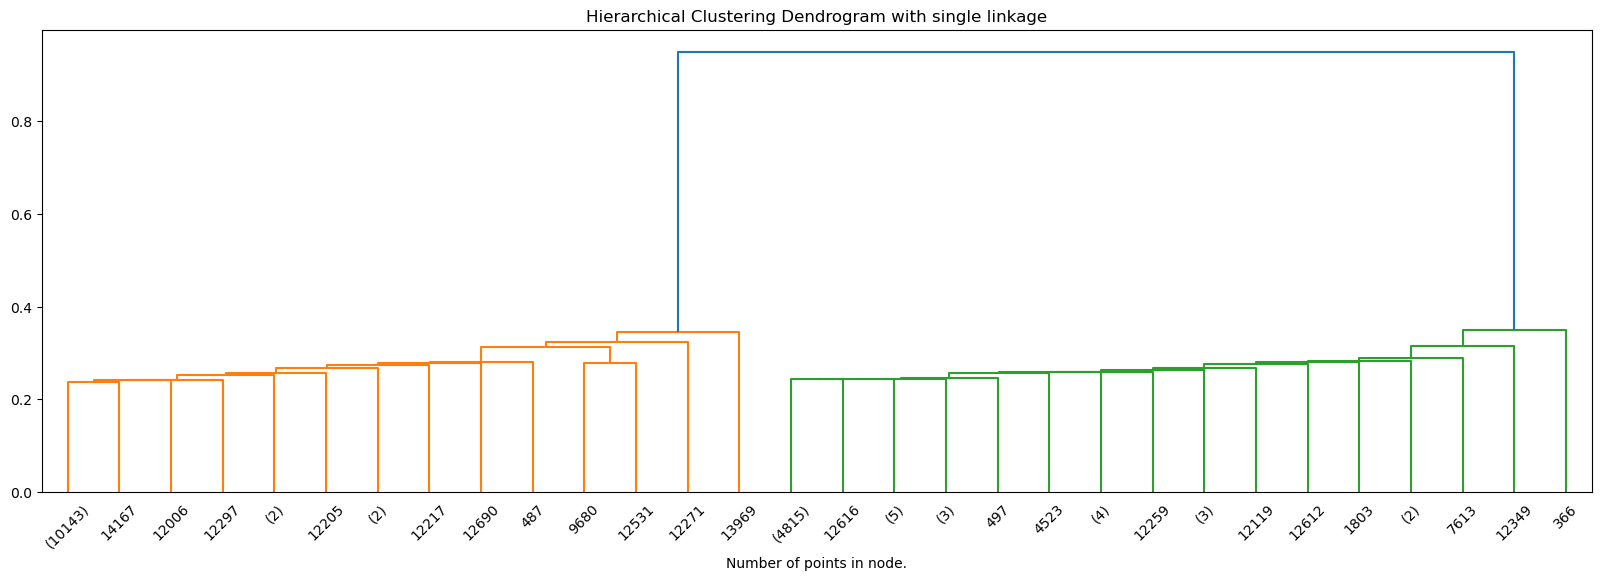

In [27]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                metric='euclidean', linkage='single')
model = model.fit(X_pca)

plt.figure(figsize=(20, 6))
plt.title("Hierarchical Clustering Dendrogram with single linkage")
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel("Number of points in node.")
plt.show()

### Calculate Silhoutte

In [24]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=0.23157894736842105, criterion='distance')

print('Silhouette', silhouette_score(X_pca, labels))

Silhouette -0.18247832134666156


### Choosing the number of clusters

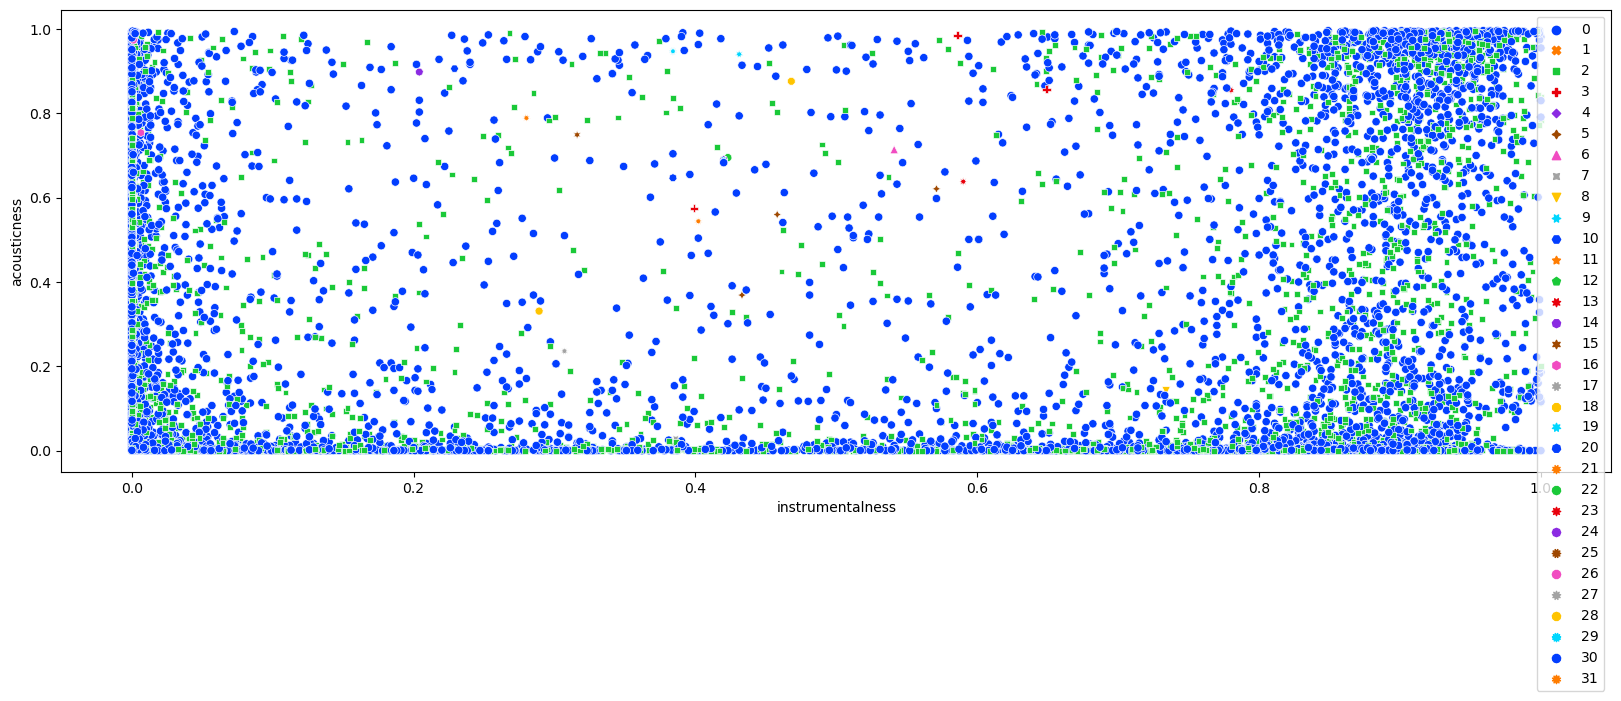

In [25]:
hier = AgglomerativeClustering(distance_threshold=0.23157894736842105, n_clusters=None, metric="euclidean", linkage='single')
hier.fit(X_pca)

plt.figure(figsize=(20, 6))

sns.scatterplot(data=df, 
                x="instrumentalness",
                y="acousticness", 
                hue=hier.labels_, 
                style=hier.labels_, 
                palette="bright")
plt.show()

### connectivity in Clustering Gerarchico
Nel contesto del clustering gerarchico, connectivity è una matrice che definisce la struttura dei dati o il modo in cui i punti dati sono connessi tra loro. Questa connettività può influenzare come i cluster vengono formati durante l'algoritmo di clustering.

kneighbors_graph: Questa funzione costruisce una matrice di connettività basata sui k vicini più prossimi di ciascun punto. In questo caso, n_neighbors=100 significa che per ogni punto dati, stai considerando i suoi 100 vicini più prossimi per definire la connettività.

include_self=False: Indica che il punto stesso non dovrebbe essere incluso nei suoi vicini più prossimi.

Utilizzare una matrice di connettività nel clustering gerarchico è utile per considerare solo certe relazioni tra i punti, ad esempio per imporre una struttura di vicinato o per lavorare con dati che hanno una struttura di rete o grafica intrinseca.

In [26]:
from sklearn.cluster import AgglomerativeClustering

# Esegui l'Hierarchical Clustering
model = AgglomerativeClustering(distance_threshold=0.231578947368421056, n_clusters=None, metric="euclidean", linkage='single')
model = model.fit(X_pca)

# Assegna le etichette dei cluster dal modello di Hierarchical Clustering
hierarchical_cluster_labels = model.labels_

# Crea una nuova colonna nel DataFrame per i cluster
df['cluster'] = hierarchical_cluster_labels

# Dato che 'genre' è stato rimosso da df e salvato in y, aggiungiamo 'genre' di nuovo a df
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


genre
0     19
1      4
2     21
3      0
4      2
5      2
6     20
7      0
8      7
9     10
10    17
11     2
12    25
13     2
14     0
15     0
16     1
17     0
18     6
19     2
dtype: int64
